# Sync Algo

In [31]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")


# def plot_accurcay(df_list):


base_path = "/home/antoniob/FederNet/results"
df_list_sync = [
    {
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A10_CSFalse",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSTrue",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSFalse",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A10_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"grpc_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSTrue",
    "model":"SCAFFOLD",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    }
]




In [32]:
def find_file_path(partial_folder_name, base_path):
    """
    Find a CSV file in a subfolder that contains the partial_folder_name.
    
    Parameters:
    - partial_folder_name: A partial name of a subfolder
    - base_path: The base directory to search in
    
    Returns:
    - Full path to the CSV file if found, None otherwise
    """
    import os
    
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains the partial name
        if partial_folder_name in os.path.basename(root):
            # Look for CSV files in this directory
            csv_files = [f for f in files if f.endswith(".csv")]
            if csv_files:
                return os.path.join(root, csv_files[0])
    print(f"Warning: No CSV file found for {partial_folder_name} in {base_path}")
    
    # If no matching subfolder or CSV file found
    return None

for df in df_list_sync:
    file_path = find_file_path(df["file_path"], base_path)
    data = pd.read_csv(file_path)
    if not data.empty:
        # Create a new row with time_sec=0 and accuracy=0
        new_row = pd.DataFrame({'time_sec': [0], 'accuracy': [0]})
        
        # Concatenate the new row with the existing data
        data = pd.concat([new_row, data]).reset_index(drop=True)
    df["data"] = data.iloc[0:31]


/tmp/ipykernel_2117357/286633894.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


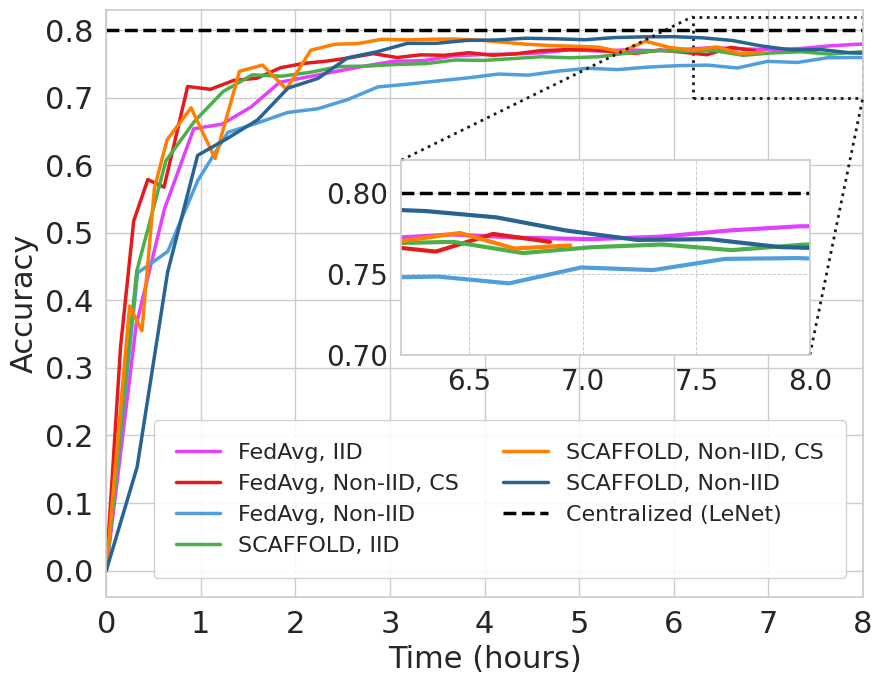

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, axis = plt.subplots(figsize=(9, 7))

colors = [
    "#E53FFF",  # Green
    "#E41A1C",  # Red
    "#4F9FDD",  # Blue
    "#4DAF4A",  # Purple
    "#FF7F00",  # Orange
    "#286394",  # Dark blue
]

for i, df_dict in enumerate(df_list_sync):
    model = df_dict["model"]
    data_dist = ", IID" if df_dict["data_distribution"] == "iid" else ", Non-IID"
    client_sel = ", CS" if df_dict["client_selection"] == "True" else ""
    label = f"{model}{data_dist}{client_sel}"    
    times = df_dict["data"]["time_sec"] / 3600  # convert to hours
    accs = df_dict["data"]["accuracy"]
    axis.plot(times, accs, label=label, color=colors[i % len(colors)], linewidth=2.5)
    # axis.scatter(times, accs, color=colors[i % len(colors)], alpha=0.15)

# Add black horizontal line at y=0.8
axis.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")

axis.set_xlim(0, 8)
axis.set_xlabel("Time (hours)", fontsize=22)
axis.set_ylabel("Accuracy", fontsize=22)
axis.tick_params(axis='both', labelsize=22)
axis.grid(True)
# axis.legend(loc="lower left", fontsize=12)
axis.legend(
    fontsize=16,
    loc="upper center",              # This sets anchor point inside bbox
    bbox_to_anchor=(0.52, 0.32),     # (x, y) in axes fraction coordinates (0 to 1)
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    ncols=2
)


# Add zoom functionality
zoom_mode = "middle"  # Options: "end" or "middle"
def add_zoom(ax, df_list):
    zx = zoomed_inset_axes(
        ax,
        1.2 if zoom_mode == "end" or zoom_mode == "bottom" else 2.4,
         bbox_to_anchor=(.45, .34, .6, .5) if zoom_mode == "end"
        else (.55, .05, .3, .25) if zoom_mode == "bottom"
        else(.38, .4, .6, .5),
        bbox_transform=ax.transAxes,
        loc=4 if zoom_mode == "end" else 8 if zoom_mode == "bottom" else 3,
    )
    zx.set_facecolor("white")
    for i, df_dict in enumerate(df_list):
        times = df_dict["data"]["time_sec"] / 3600
        accs = df_dict["data"]["accuracy"]
        zx.plot(times, accs, color=colors[i % len(colors)], linewidth=3)
        # zx.scatter(times, accs, color=colors[i % len(colors)], alpha=0.25)
    
    x1, x2 = 6.2, 8  # Time range to zoom in (hours)
    y1, y2 = 0.7, 0.82 # Accuracy range to zoom in 
    zx.set_xlim(x1, x2)
    zx.set_ylim(y1, y2)
    zx.grid(True, linestyle='--', linewidth=0.7)
    zx.tick_params(labelsize=20)
    # Add black horizontal line at y=0.8
    zx.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")
    mark_inset(ax, zx, loc1=2, loc2=4, fc="none", ec="0.1", linestyle="dotted", linewidth=2)


add_zoom(axis, df_list_sync)

plt.tight_layout()
plt.savefig("syn_time.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2117357/3093187873.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


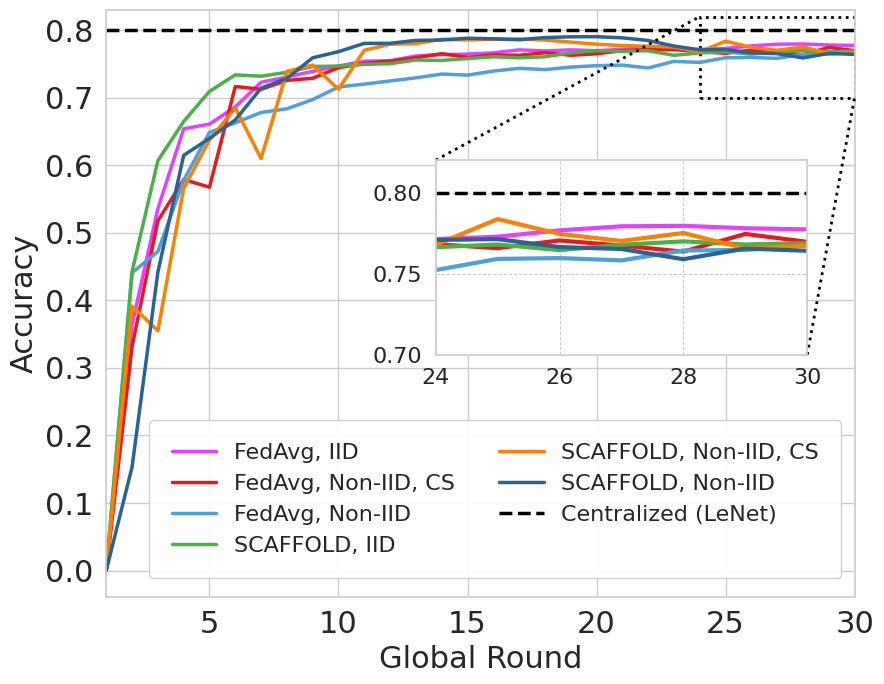

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, axis = plt.subplots(figsize=(9, 7))  # Changed from (12, 6) to match original

colors = [
    "#E53FFF",  # Green
    "#E41A1C",  # Red
    "#4F9FDD",  # Blue
    "#4DAF4A",  # Purple
    "#FF7F00",  # Orange
    "#286394",  # Dark blue
]

for i, df_dict in enumerate(df_list_sync):
    model = df_dict["model"]
    data_dist = ", IID" if df_dict["data_distribution"] == "iid" else ", Non-IID"
    client_sel = ", CS" if df_dict["client_selection"] == "True" else ""
    label = f"{model}{data_dist}{client_sel}"
    rounds = list(range(len(df_dict["data"])))
    accs = df_dict["data"]["accuracy"]
    axis.plot(rounds, accs, label=label, color=colors[i % len(colors)], linewidth=2.5)  # Added linewidth=3
    # axis.scatter(rounds, accs, color=colors[i % len(colors)], alpha=0.15)

# Add black horizontal line at y=0.8
axis.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")  # Changed from 1.5 to 3
axis.set_xlim(1, 30)  
axis.set_xlabel("Global Round", fontsize=22)  # Changed from 14 to 22
axis.set_ylabel("Accuracy", fontsize=22)  # Changed from 14 to 22
axis.tick_params(axis='both', labelsize=22)  # Changed from 12 to 22
axis.grid(True)
# Changed legend to match original positioning and styling
axis.legend(
    fontsize=16,
    loc="upper center",              # This sets anchor point inside bbox
    bbox_to_anchor=(0.52, 0.32),     # (x, y) in axes fraction coordinates (0 to 1)
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    ncols=2
)

# Add zoom functionality
zoom_mode = "middle"  # Changed from "bottom" to "middle" to match original
def add_zoom(ax, df_list):
    zx = zoomed_inset_axes(ax, 1.2 if zoom_mode == "end" or zoom_mode == "bottom" else 2.4,
                            bbox_to_anchor=(.45, .34, .6, .5) if zoom_mode == "end"
                            else (.55, .05, .3, .25) if zoom_mode == "bottom"
                            else(.43, .4, .6, .5), # Updated positioning
                           bbox_transform=ax.transAxes,
                           loc=4 if zoom_mode=="end" else 8 if zoom_mode=="bottom" else 3)
    zx.set_facecolor("white")  # Added white background for zoom box
    for i, df_dict in enumerate(df_list):
        rounds = list(range(len(df_dict["data"])))
        accs = df_dict["data"]["accuracy"]
        zx.plot(rounds, accs, color=colors[i % len(colors)], linewidth=3)
        # zx.scatter(rounds, accs, color=colors[i % len(colors)], alpha=0.25)
    
    x1, x2 = 24, 30  # Keep your round range
    y1, y2 = 0.70, 0.82  # Keep your accuracy range
    zx.set_xlim(x1, x2)
    zx.set_ylim(y1, y2)
    zx.grid(True, linestyle='--', linewidth=0.7)
    zx.tick_params(labelsize=16)
    # Add black horizontal line at y=0.8
    zx.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")  # Changed from 1.5 to 3
    mark_inset(ax, zx, loc1=2, loc2=4, fc="none", ec="black", linestyle="dotted", linewidth=2)

add_zoom(axis, df_list_sync)

plt.tight_layout()
plt.savefig("syn_rounds.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()

# ASync Algo

In [45]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")


# def plot_accurcay(df_list):


base_path = "/home/antoniob/FederNet/results"
df_list_async = [
    {
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A10_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-06-18-01-11-54_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A10_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-03-17-45-48_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A10_CSFalse",
    "model":"FedAsync",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-05-10-08-54_mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A10_CSFalse",
    "model":"Unweighted",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-03-21-56-15_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A0.5_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-05-02-10-11_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A0.5_CSFalse",
    "model":"FedAsync",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A0.5_CSFalse",
    "model":"Unweighted",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    }, {
    "file_path":"2025-07-09-11-43-23_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A0.5_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },
]




In [50]:
def find_file_path(partial_folder_name, base_path):
    """
    Find a CSV file in a subfolder that contains the partial_folder_name.
    
    Parameters:
    - partial_folder_name: A partial name of a subfolder
    - base_path: The base directory to search in
    
    Returns:
    - Full path to the CSV file if found, None otherwise
    """
    import os
    
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains the partial name
        if partial_folder_name in os.path.basename(root):
            # Look for CSV files in this directory
            csv_files = [f for f in files if f.endswith(".csv")]
            if csv_files:
                return os.path.join(root, csv_files[0])
    print(f"Warning: No CSV file found for {partial_folder_name} in {base_path}")
    
    # If no matching subfolder or CSV file found
    return None

for df in df_list_async:
    file_path = find_file_path(df["file_path"], base_path)
    data = pd.read_csv(file_path)
    if not data.empty:
        # Create a new row with time_sec=0 and accuracy=0
        new_row = pd.DataFrame({'time_sec': [0], 'accuracy': [0]})
        
        # Concatenate the new row with the existing data
        data = pd.concat([new_row, data]).reset_index(drop=True)
    df["data"] = data.iloc[0:1000]


**ASYNC IID CASE**

/tmp/ipykernel_2117357/319098002.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


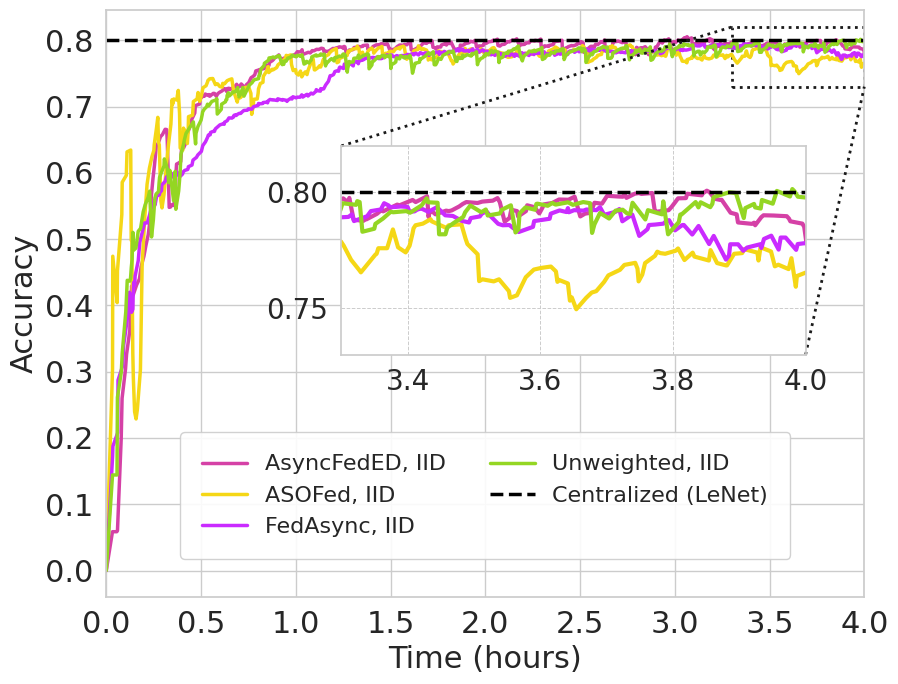

In [50]:
# IID ASYNC
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")


# def plot_accurcay(df_list):


base_path = "/home/antoniob/FederNet/results"
df_list_async_iid = [
    {
    "file_path":"2025-07-10-00-30-26_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A10_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-10-04-42-07_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A10_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-03-17-45-48_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A10_CSFalse",
    "model":"FedAsync",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-05-10-08-54_mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A10_CSFalse",
    "model":"Unweighted",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },
]

def find_file_path(partial_folder_name, base_path):
    """
    Find a CSV file in a subfolder that contains the partial_folder_name.
    
    Parameters:
    - partial_folder_name: A partial name of a subfolder
    - base_path: The base directory to search in
    
    Returns:
    - Full path to the CSV file if found, None otherwise
    """
    import os
    
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains the partial name
        if partial_folder_name in os.path.basename(root):
            # Look for CSV files in this directory
            csv_files = [f for f in files if f.endswith(".csv")]
            if csv_files:
                return os.path.join(root, csv_files[0])
    print(f"Warning: No CSV file found for {partial_folder_name} in {base_path}")
    
    # If no matching subfolder or CSV file found
    return None

for df in df_list_async_iid:
    file_path = find_file_path(df["file_path"], base_path)
    data = pd.read_csv(file_path)
    if not data.empty:
        # Create a new row with time_sec=0 and accuracy=0
        new_row = pd.DataFrame({'time_sec': [0], 'accuracy': [0]})
        
        # Concatenate the new row with the existing data
        data = pd.concat([new_row, data]).reset_index(drop=True)
    df["data"] = data.iloc[0:1000]

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, axis = plt.subplots(figsize=(9, 7))

colors = [
    "#D541A6FF", "#F5D716", "#CA2BFF", "#94D623", "#00CED1", "#FF5733", "#8B4513", "#808080" 
]

for i, df_dict in enumerate(df_list_async_iid):
    model = df_dict["model"]
    data_dist = ", IID" if df_dict["data_distribution"] == "iid" else ", Non-IID"
    client_sel = ", CS" if df_dict["client_selection"] == "True" else ""
    label = f"{model}{data_dist}{client_sel}"
    times = df_dict["data"]["time_sec"] / 3600  # convert to hours
    accs = df_dict["data"]["accuracy"]
    axis.plot(times, accs, label=label, color=colors[i % len(colors)], linewidth=2.5)
    # axis.scatter(times, accs, color=colors[i % len(colors)], alpha=0.15)

axis.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")
axis.set_xlim(0, 4)
axis.set_xlabel("Time (hours)", fontsize=22)
axis.set_ylabel("Accuracy", fontsize=22)
axis.tick_params(axis='both', labelsize=22)
axis.grid(True)

axis.legend(
    fontsize=16,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.3),
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    ncols=2
)

# Add zoom functionality
zoom_mode = "middle"  # Options: "end", "bottom", "middle"
def add_zoom(ax, df_list):
    zx = zoomed_inset_axes(
        ax,
        1.2 if zoom_mode == "end" or zoom_mode == "bottom" else 3.5,
         bbox_to_anchor=(.45, .34, .6, .5) if zoom_mode == "end"
        else (.55, .05, .3, .25) if zoom_mode == "bottom"
        else(.3, .4, .6, .5),
        bbox_transform=ax.transAxes,
        loc=4 if zoom_mode == "end" else 8 if zoom_mode == "bottom" else 3,
    )
    zx.set_facecolor("white")
    for i, df_dict in enumerate(df_list):
        times = df_dict["data"]["time_sec"] / 3600
        accs = df_dict["data"]["accuracy"]
        zx.plot(times, accs, color=colors[i % len(colors)], linewidth=3)
        # zx.scatter(times, accs, color=colors[i % len(colors)], alpha=0.25)

    x1, x2 = 3.3,4
    y1, y2 = 0.73, 0.82
    zx.set_xlim(x1, x2)
    zx.set_ylim(y1, y2)
    zx.grid(True, linestyle='--', linewidth=0.7)
    zx.tick_params(labelsize=20)
    zx.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5)
    mark_inset(ax, zx, loc1=2, loc2=4, fc="none", ec="0.1", linestyle="dotted", linewidth=2)

add_zoom(axis, df_list_async_iid)

plt.tight_layout()
plt.savefig("async_IID.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_2117357/3716300607.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


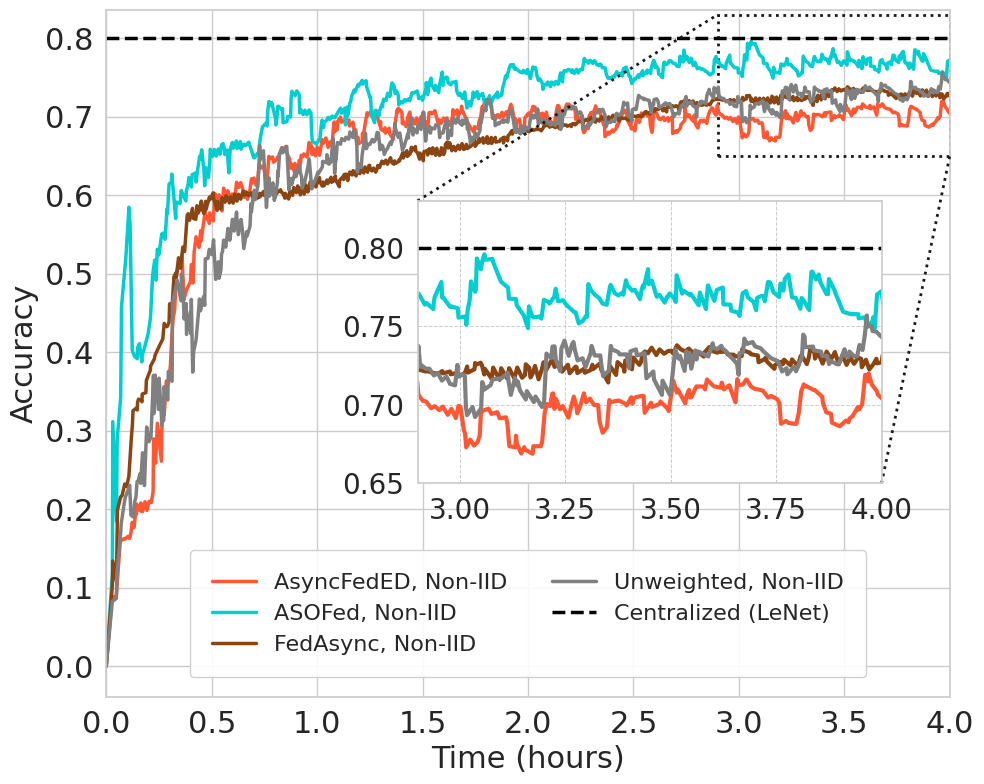

In [78]:
# non-IID ASYNC
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")


# def plot_accurcay(df_list):


base_path = "/home/antoniob/FederNet/results"
df_list_async_iid = [
    {
    "file_path":"2025-07-03-21-56-15_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A0.5_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-09-11-43-23_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A0.5_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-05-02-10-11_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A0.5_CSFalse",
    "model":"FedAsync",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"2025-07-09-16-15-25_mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A0.5_CSFalse",
    "model":"Unweighted",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    }
]

def find_file_path(partial_folder_name, base_path):
    """
    Find a CSV file in a subfolder that contains the partial_folder_name.
    
    Parameters:
    - partial_folder_name: A partial name of a subfolder
    - base_path: The base directory to search in
    
    Returns:
    - Full path to the CSV file if found, None otherwise
    """
    import os
    
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains the partial name
        if partial_folder_name in os.path.basename(root):
            # Look for CSV files in this directory
            csv_files = [f for f in files if f.endswith(".csv")]
            if csv_files:
                return os.path.join(root, csv_files[0])
    print(f"Warning: No CSV file found for {partial_folder_name} in {base_path}")
    
    # If no matching subfolder or CSV file found
    return None

for df in df_list_async_iid:
    file_path = find_file_path(df["file_path"], base_path)
    data = pd.read_csv(file_path)
    if not data.empty:
        # Create a new row with time_sec=0 and accuracy=0
        new_row = pd.DataFrame({'time_sec': [0], 'accuracy': [0]})
        
        # Concatenate the new row with the existing data
        data = pd.concat([new_row, data]).reset_index(drop=True)
    df["data"] = data.iloc[0:1000]

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, axis = plt.subplots(figsize=(10, 8))

colors = [
    "#FF5733","#00CED1", "#8B4513", "#808080" 
]

for i, df_dict in enumerate(df_list_async_iid):
    model = df_dict["model"]
    data_dist = ", IID" if df_dict["data_distribution"] == "iid" else ", Non-IID"
    client_sel = ", CS" if df_dict["client_selection"] == "True" else ""
    label = f"{model}{data_dist}{client_sel}"
    times = df_dict["data"]["time_sec"] / 3600  # convert to hours
    accs = df_dict["data"]["accuracy"]
    axis.plot(times, accs, label=label, color=colors[i % len(colors)], linewidth=2.5)
    # axis.scatter(times, accs, color=colors[i % len(colors)], alpha=0.15)

axis.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")
axis.set_xlim(0, 4)
axis.set_xlabel("Time (hours)", fontsize=22)
axis.set_ylabel("Accuracy", fontsize=22)
axis.tick_params(axis='both', labelsize=22)
axis.grid(True)

axis.legend(
    fontsize=16,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.23),
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    ncols=2
)

# Add zoom functionality
zoom_mode = "middle"  # Options: "end", "bottom", "middle"
def add_zoom(ax, df_list):
    zx = zoomed_inset_axes(
        ax,
        1.2 if zoom_mode == "end" or zoom_mode == "bottom" else 2,
         bbox_to_anchor=(.45, .34, .6, .5) if zoom_mode == "end"
        else (.55, .05, .3, .25) if zoom_mode == "bottom"
        else(.36, .3, .6, .5),
        bbox_transform=ax.transAxes,
        loc=4 if zoom_mode == "end" else 8 if zoom_mode == "bottom" else 3,
    )
    zx.set_facecolor("white")
    for i, df_dict in enumerate(df_list):
        times = df_dict["data"]["time_sec"] / 3600
        accs = df_dict["data"]["accuracy"]
        zx.plot(times, accs, color=colors[i % len(colors)], linewidth=3)
        # zx.scatter(times, accs, color=colors[i % len(colors)], alpha=0.25)
        
    x1, x2 = 2.9, 4  # Adjust if needed
    y1, y2 = 0.65, 0.83
    zx.set_xlim(x1, x2)
    zx.set_ylim(y1, y2)
    zx.grid(True, linestyle='--', linewidth=0.7)
    zx.tick_params(labelsize=20)
    zx.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5)
    mark_inset(ax, zx, loc1=2, loc2=4, fc="none", ec="0.1", linestyle="dotted", linewidth=2)

add_zoom(axis, df_list_async_iid)

plt.tight_layout()
plt.savefig("async_nonIID.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()


**BEST RESULTS**

In [63]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")


# def plot_accurcay(df_list):


base_path = "/home/antoniob/FederNet/results"
df_list_async = [
    {
     "file_path":"mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A10_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",},
    {
    "file_path":"grpc_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSTrue",
    "model":"SCAFFOLD",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },
    {
    "file_path":"2025-07-10-00-30-26_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A10_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    }, {
    "file_path":"2025-07-09-11-43-23_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A0.5_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    }
]


In [64]:
def find_file_path(partial_folder_name, base_path):
    """
    Find a CSV file in a subfolder that contains the partial_folder_name.
    
    Parameters:
    - partial_folder_name: A partial name of a subfolder
    - base_path: The base directory to search in
    
    Returns:
    - Full path to the CSV file if found, None otherwise
    """
    import os
    
    for root, dirs, files in os.walk(base_path):
        # Check if the current directory contains the partial name
        if partial_folder_name in os.path.basename(root):
            # Look for CSV files in this directory
            csv_files = [f for f in files if f.endswith(".csv")]
            if csv_files:
                return os.path.join(root, csv_files[0])
    print(f"Warning: No CSV file found for {partial_folder_name} in {base_path}")
    
    # If no matching subfolder or CSV file found
    return None

for df in df_list_async:
    file_path = find_file_path(df["file_path"], base_path)
    data = pd.read_csv(file_path)
    if not data.empty:
        # Create a new row with time_sec=0 and accuracy=0
        new_row = pd.DataFrame({'time_sec': [0], 'accuracy': [0]})
        
        # Concatenate the new row with the existing data
        data = pd.concat([new_row, data]).reset_index(drop=True)
    df["data"] = data.iloc[0:1000]


/tmp/ipykernel_2117357/1549034068.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


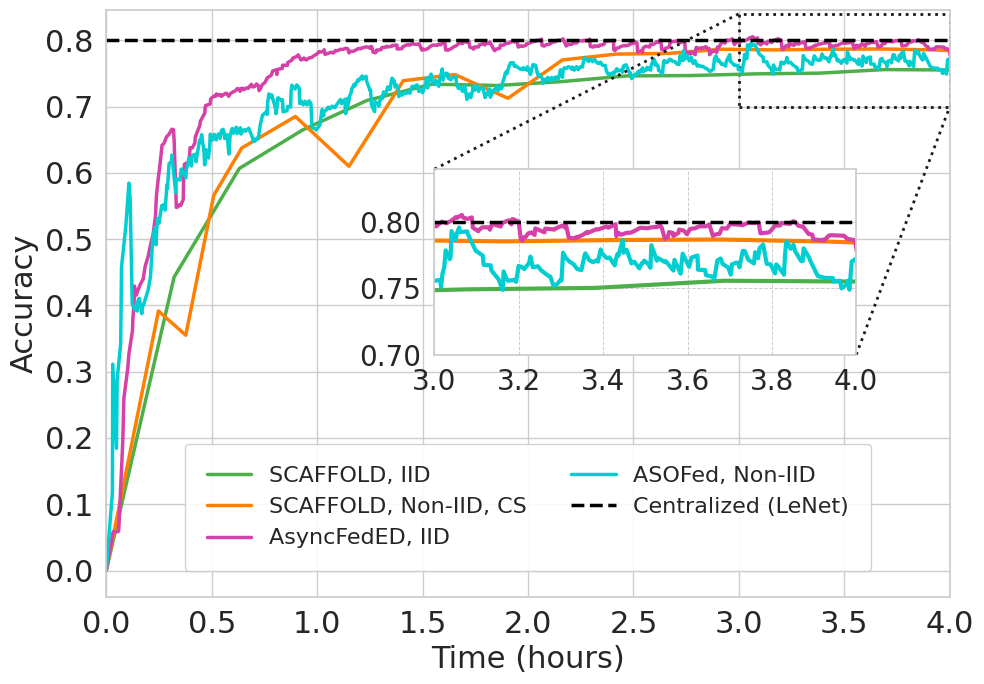

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

fig, axis = plt.subplots(figsize=(10, 7))

colors = [
    "#4DAF4A",  # Green
    "#FF7F00",  # Orange
    "#D541A6",  # Pink/Purple
    "#00CED1"   # Cyan
]

for i, df_dict in enumerate(df_list_async):
    model = df_dict["model"]
    data_dist = ", IID" if df_dict["data_distribution"] == "iid" else ", Non-IID"
    client_sel = ", CS" if df_dict["client_selection"] == "True" else ""
    label = f"{model}{data_dist}{client_sel}"
    
    times = df_dict["data"]["time_sec"] / 3600  # convert to hours
    accs = df_dict["data"]["accuracy"]
    axis.plot(times, accs, label=label, color=colors[i % len(colors)], linewidth=2.5)

# Add black horizontal line at y=0.8
axis.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5, label="Centralized (LeNet)")

axis.set_xlim(0, 4)
axis.set_xlabel("Time (hours)", fontsize=22)
axis.set_ylabel("Accuracy", fontsize=22)
axis.tick_params(axis='both', labelsize=22)
axis.grid(True)

# Legend styling
axis.legend(
    fontsize=16,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.28),
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    ncols=2
)

# Add zoom functionality
zoom_mode = "middle"  # Options: "end", "bottom", or "middle"
def add_zoom(ax, df_list):
    zx = zoomed_inset_axes(
        ax,
        1.2 if zoom_mode == "end" or zoom_mode == "bottom" else 2,
         bbox_to_anchor=(.45, .34, .6, .5) if zoom_mode == "end"
        else (.55, .05, .3, .25) if zoom_mode == "bottom"
        else(.38, .4, .6, .5),
        bbox_transform=ax.transAxes,
        loc=4 if zoom_mode == "end" else 8 if zoom_mode == "bottom" else 3,
    )
    zx.set_facecolor("white")
    
    for i, df_dict in enumerate(df_list):
        times = df_dict["data"]["time_sec"] / 3600
        accs = df_dict["data"]["accuracy"]
        zx.plot(times, accs, color=colors[i % len(colors)], linewidth=3)
    
    x1, x2 = 3, 4  # Adjust if needed
    y1, y2 = 0.7, 0.84
    zx.set_xlim(x1, x2)
    zx.set_ylim(y1, y2)
    zx.grid(True, linestyle='--', linewidth=0.7)
    zx.tick_params(labelsize=20)
    zx.axhline(y=0.8, color='black', linestyle='--', linewidth=2.5)
    mark_inset(ax, zx, loc1=2, loc2=4, fc="none", ec="0.1", linestyle="dotted", linewidth=2)

add_zoom(axis, df_list_async)


plt.tight_layout()
plt.savefig("comparison.svg", format="svg", dpi=300, bbox_inches='tight')
plt.show()
